In [18]:
import torch.nn
from audio_image_pipeline import *  
import torch 
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import librosa
import os
from torch.utils.data import Dataset


(12678, 128, 126)


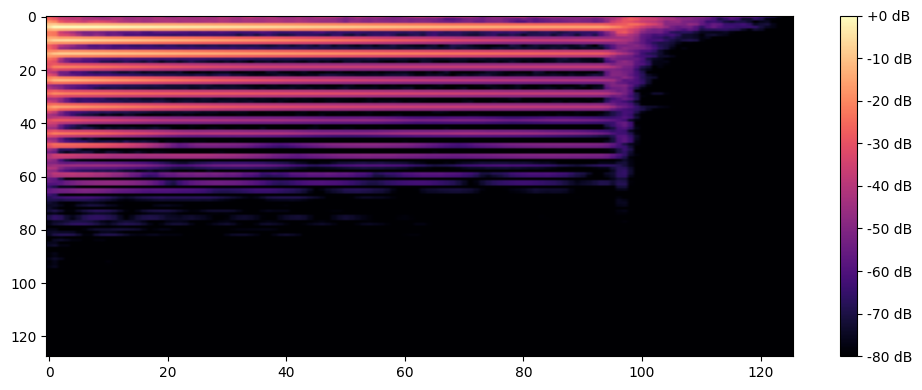

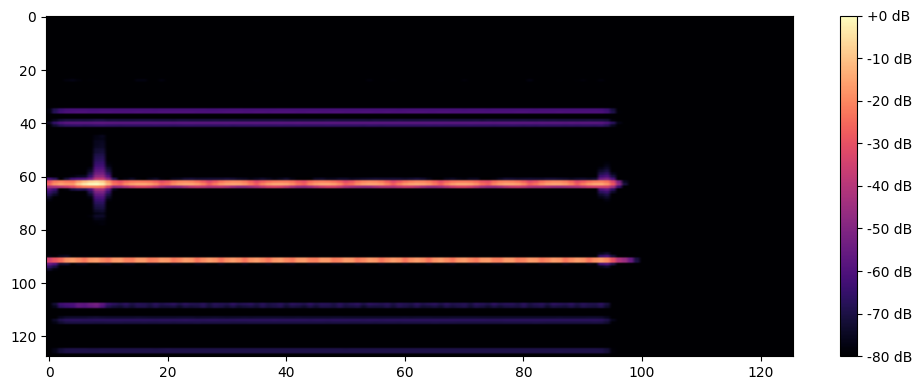

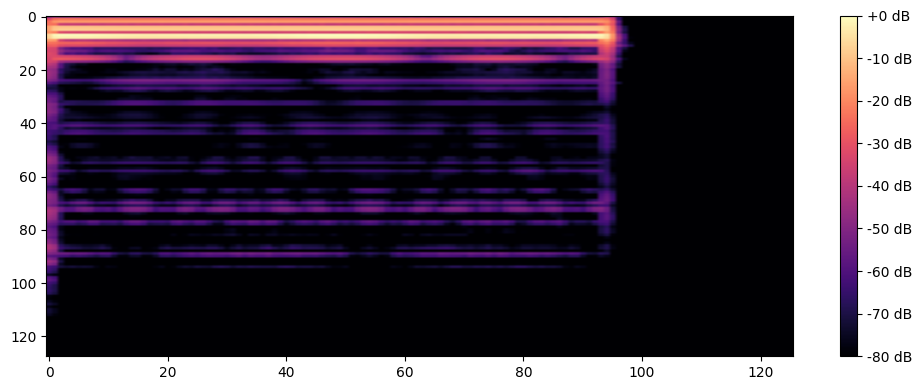

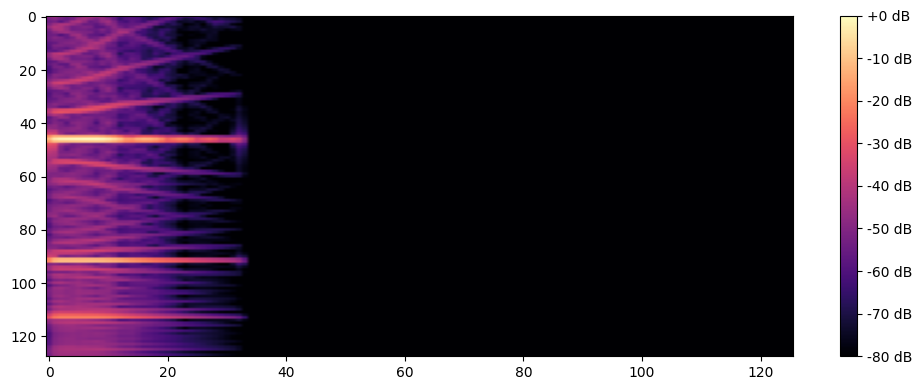

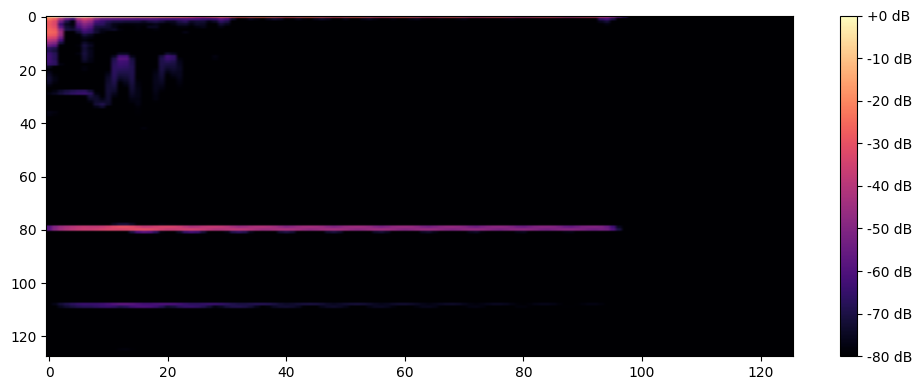

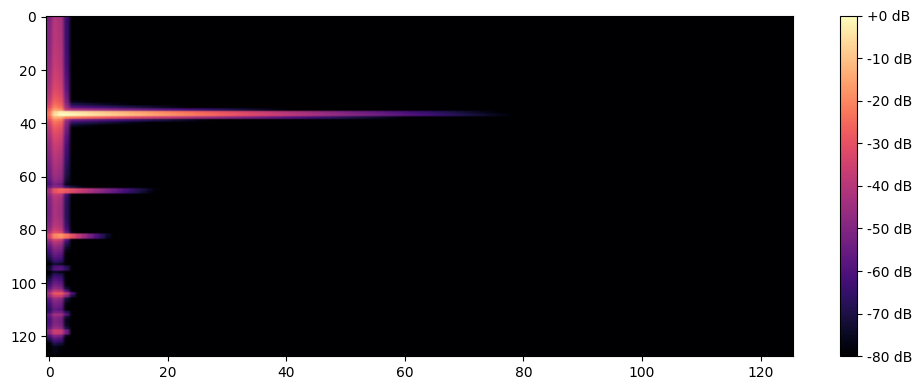

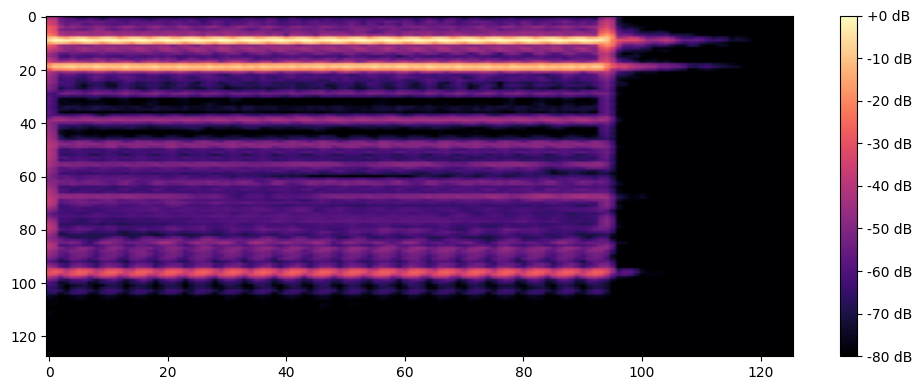

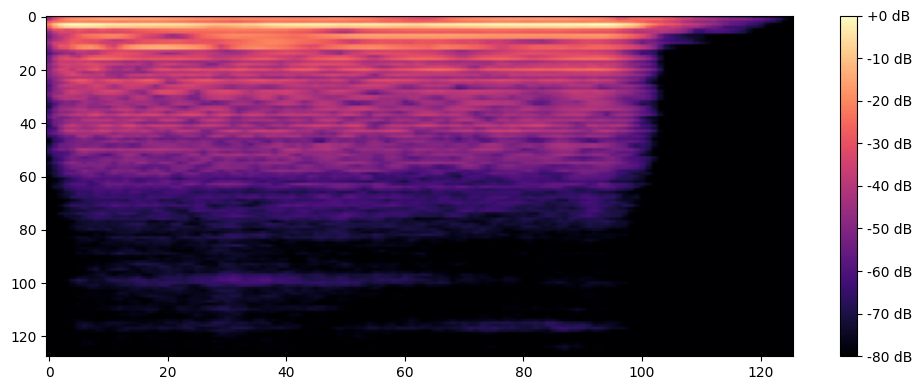

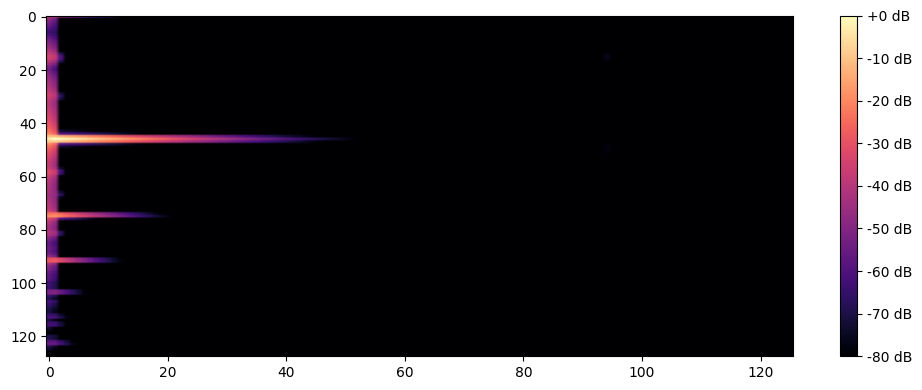

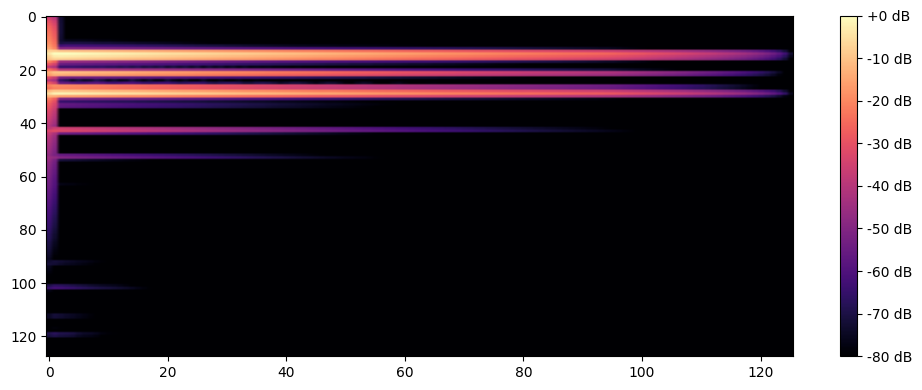

In [35]:
data_path = 'data/nsynth-valid/' # <-- insert path to data
audio_path = data_path+'audio/' # Path for audio files
spectograms = [] 
for fname in os.listdir(audio_path):
    if not fname.endswith('.wav'):
        continue
    spec_t = audio_to_melspectrogram(
        os.path.join(audio_path, fname),
        sr=16000, n_mels=128, hop_length=512
    )
    spectograms.append(spec_t.numpy())

# stack into array of shape (N, 128, T)
data = np.stack(spectograms, axis=0)
print(data.shape)

for i in range (10):
    plt.figure(figsize=(10,4))
    plt.imshow(data[i], aspect='auto', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

In [36]:
def audio_to_melspectrogram(audio_path, sr=22050, n_mels=128, hop_length=512):
    y, sr = librosa.load(audio_path, sr=sr)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return torch.tensor(S_dB, dtype=torch.float32)



In [37]:
audio_folder = 'data/nsynth-valid/audio' 
output_folder = 'spectrogram_tensors'

os.makedirs(output_folder, exist_ok=True)
audio_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(audio_folder) for f in filenames if f.endswith('.wav')]
for path in audio_files:
    tensor = audio_to_melspectrogram(path)
    
    tensor = (tensor + 80) / 80  
    filename = os.path.basename(path).replace('.wav', '.pt')
    save_path = os.path.join(output_folder, filename)
    torch.save(tensor, save_path)

print(f"{len(audio_files)}")

KeyboardInterrupt: 

In [19]:
# Building an autoregressive mask 
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True): 
        super().__init__(in_features, out_features, bias)
        
        self.mask = torch.zeros(out_features, in_features) # same shape like weight matrix at the beginning fully connected no sparse 

    def set_mask(self, mask):
        self.mask.copy_(mask)

    def forward(self, input):
        return nn.functional.linear(input, self.weight * self.mask, self.bias) # if mask 0 output will be 0 -> masking 

def create_autoregressive_mask(in_features, out_features):
    mask = torch.zeros(out_features, in_features) 
    for i in range(out_features):
        for j in range(in_features):
            if j <= i:  # ensures that model does not look in the future
                mask[i, j] = 1
    return mask


In [20]:
# Neuronal Netowrk on which we apply to mask 
class MLP_Masked(nn.Module):
    def __init__(self, input_dim=22144, hidden_dims=[1024, 1024]):
        super().__init__()
        self.architecture = nn.ModuleList()
        in_dim = input_dim

        for h_dim in hidden_dims:
            linear = MaskedLinear(in_dim, h_dim)
            mask = create_autoregressive_mask(in_dim, h_dim)
            linear.set_mask(mask)

            layer = nn.Sequential(
                linear,
                nn.ReLU()
            )
            self.architecture.append(layer)
            in_dim = h_dim

        # Output layer: 2 * input_dim, to split it into s and t such that we can use them as input phi for our invertible function
        self.output_layer = MaskedLinear(in_dim, 2 * input_dim) # we make the output layer 2 times bigger than the input layer since out convertable function needs s and t!!!
        out_mask = create_autoregressive_mask(in_dim, 2 * input_dim)
        self.output_layer.set_mask(out_mask)

    def forward(self, x):
        for layer in self.architecture:
            x = layer(x)
        return self.output_layer(x)  
    

In [21]:
def invertible_function(output_of_network, real_data):
    dim = real_data.shape[1]
    s = output_of_network[:, :dim]
    t = output_of_network[:, dim:]
    
    # we have to seet boundaries for s otherwise it goes into millions or milliarden idk 
    s = torch.clamp(s, min=-5, max=5)
    
    z = (real_data - t) * torch.exp(-s)
    return z, s

def norm_log_prob(z, mean=0.0, std_dev=1.0):
    pi = torch.tensor(np.pi, dtype=z.dtype, device=z.device)  
    coeff = -0.5 * torch.log(2 * pi) - torch.log(torch.tensor(std_dev, dtype=z.dtype, device=z.device))
    exponent = -0.5 * ((z - mean) / std_dev) ** 2
    return coeff + exponent

def log_det_jacobian(s):
    # pro Sample über Features summieren
    return torch.sum(s, dim=1)  # shape: [batch_size]

def change_of_variable(log_p_z, log_det_jacobian):
    # log_p_z hat Shape [batch_size, dim], wir summieren Features pro Sample
    log_p_z_sum = torch.sum(log_p_z, dim=1)  # shape: [batch_size]
    log_p_x = log_p_z_sum + log_det_jacobian  # shape: [batch_size]
    return log_p_x

def Loss(log_p_x): 
    # Mittelwert über Batch
    return -torch.mean(log_p_x)

## Now we need to program the inverse map to be able to train 

In [22]:
from datasets import HDF5SpectrogramDataset
dataset = HDF5SpectrogramDataset('data/train_spectrograms_even.h5')
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [24]:
sample = dataset[0]
print(sample.shape)

torch.Size([128, 172])


In [ ]:
train_epoch

In [25]:
model = MLP_Masked()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    for batch in loader: 
        optimizer.zero_grad()

        batch = batch.float()  # only if necessary to be on the safe side not on the side of dave vadea 

        batch_flat = batch.view(batch.size(0), -1) 

        out = model(batch_flat) 

        z, s = invertible_function(out, batch_flat) 

        log_p_z = norm_log_prob(z)
        log_det = log_det_jacobian(s)
        log_p_x = change_of_variable(log_p_z, log_det) 

        loss = Loss(log_p_x) 
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, z.mean: {z.mean().item():.4f}, s.mean: {s.mean().item():.4f}")

KeyboardInterrupt: 

## Now we go the inverse path in order to calculate 

In [ ]:
# creating new sample via inverse path
def sample_one(model, input_dim=128*172):
    with torch.no_grad():
        z = torch.randn(1, input_dim)  # random tensor from latent space
        output = model(z) 
        s, t = output[:, :input_dim], output[:, input_dim:]
        s = torch.clamp(s, -5, 5)  # normalising like in training
        x = z * torch.exp(s) + t    # Inverse path from our invertible function we defined before
    return x.squeeze(0).numpy()    


def plot_samples(samples, freq_bins=128, time_steps=173, n_rows=2, n_cols=5):
    plt.figure(figsize=(15, 6))
    for i, sample in enumerate(samples):
        sample_2d = sample.reshape(freq_bins, time_steps)
        sample_2d = np.clip(sample_2d, -5, 5)
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(sample_2d, aspect='auto', origin='lower', cmap='inferno', vmin=-5, vmax=5)
        plt.title(f"Sample {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

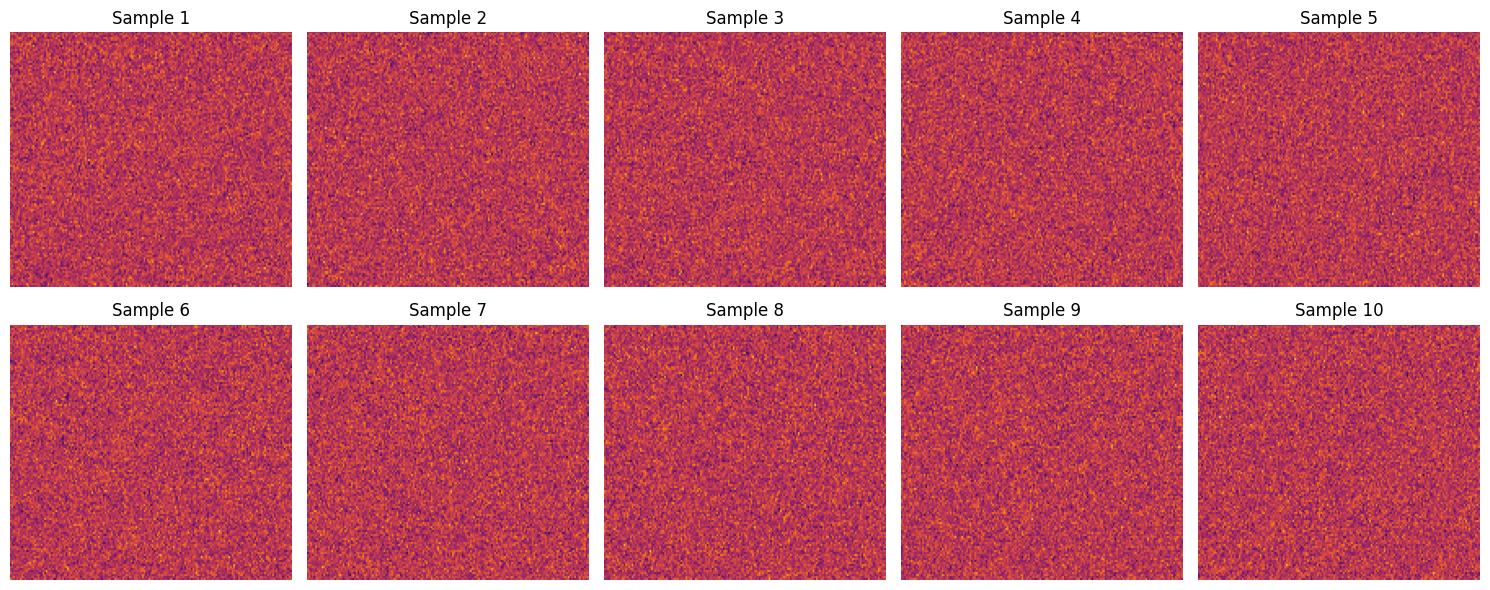

In [43]:
samples = [sample_one(model, input_dim=128*173) for _ in range(10)]
plot_samples(samples)

Unfortunatley they all look not really good, this is probably due to the model which got trained but not good enough. Therefore it would be nice for use to train the model even longer and harder in order to create better outputs and therefore better music..